In [1]:
import submitit
import os
import glob
import numpy as np
import pandas as pd
import mne
import submitit
import mne
import numpy as np
from tensorpac import Pac
import matplotlib.pyplot as plt
import os
import urllib
import pandas as pd
import numpy as np
from scipy.io import loadmat

from tensorpac import Pac, EventRelatedPac, PreferredPhase
from tensorpac.utils import PeakLockedTF, PSD, ITC, BinAmplitude

erpac_febb430e-2d50-4f83-87a0-b5ffbb9a4943_VISp6a_352


Reading /mnt/data/AdaptiveControl/IBLrawdata/pid_data/febb430e-2d50-4f83-87a0-b5ffbb9a4943/lfp_febb430e-2d50-4f83-87a0-b5ffbb9a4943_epoched.fif ...
Isotrak not found
    Found the data of interest:
        t =   -1000.00 ...    2000.00 ms
        0 CTF compensation matrices available


/tmp/ipykernel_204066/989992176.py:10: RuntimeWarning: This filename (/mnt/data/AdaptiveControl/IBLrawdata/pid_data/febb430e-2d50-4f83-87a0-b5ffbb9a4943/lfp_febb430e-2d50-4f83-87a0-b5ffbb9a4943_epoched.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epoch_path, preload=True)


Adding metadata with 16 columns
402 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_204066/989992176.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epoch.get_data().squeeze()  # Shape: (n_epochs, n_channels, n_times)
PeakLockedTF object defined
    align on time-point=0.2 (sample=599)
    extract phase and amplitudes (n_amps=65)
    running peak detection around sample=599
    realign the 174 phases and amplitudes


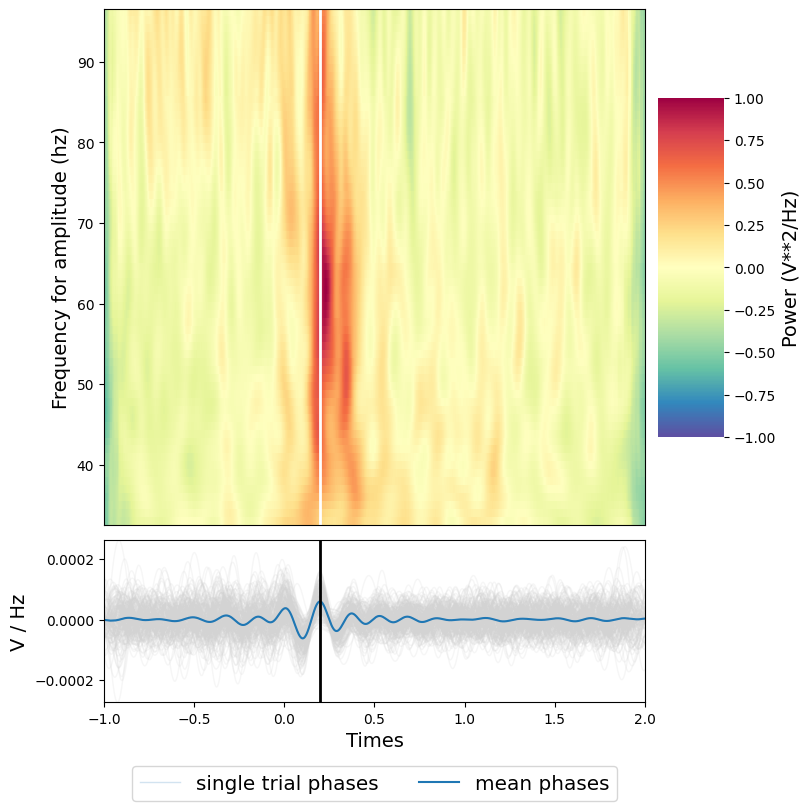

In [6]:

pid = 'febb430e-2d50-4f83-87a0-b5ffbb9a4943'

epoch_path = f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/lfp_{pid}_epoched.fif'



# Load metadata

# Load the epochs
epochs = mne.read_epochs(epoch_path, preload=True)
times = epochs.times
sf = epochs.info['sfreq']
meta = epochs.metadata.reset_index()
for i, ch in enumerate(epochs.ch_names):
    
    if not ch == 'VISp4_382':
        
        continue
        

    epoch = epochs.copy().pick_channels([ch])

    
    # Extract data from epochs
    data = epoch.get_data().squeeze()  # Shape: (n_epochs, n_channels, n_times)
    # Define condition trials based on the condition parameter
    stim_indices = np.where(((meta['contrastLeft'] > 0.2) | (meta['contrastRight'] > 0.2)))[0]
    # Select data for each condition
    data = data[stim_indices]
    
    cue = 0.2               # time-point of reference (in seconds)
    f_pha = [2, 7]           # single frequency phase interval
    f_amp = (30, 100, 5, 1)  # amplitude frequencies
    p_obj = PeakLockedTF(data, sf, cue, times=times, f_pha=f_pha, f_amp= f_amp)
    plt.figure(figsize=(8, 9))
    title = 'Peak-Locked TF representation according to phase 2 - 7 Hz'
    p_obj.plot(zscore=True, vmin=-1, vmax=1, cmap='Spectral_r')

Binning [20, 80]Hz amplitude according to [2, 8]Hz phase
Binning [20, 80]Hz amplitude according to [2, 8]Hz phase
Binning [20, 80]Hz amplitude according to [2, 8]Hz phase
Binning [20, 80]Hz amplitude according to [2, 8]Hz phase


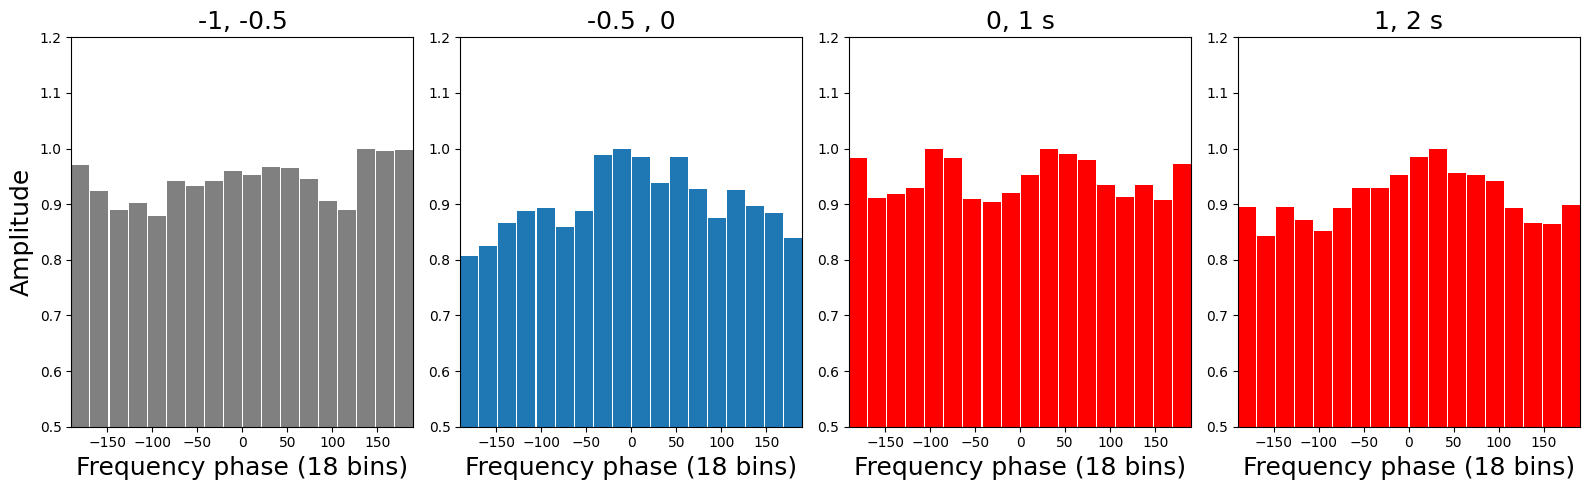

In [8]:
time_0_250ms = slice(0, 250)
time_250_500ms = slice(250, 500)
time_500_1000ms = slice(500, 750)
time_1000_1500ms = slice(750, 1000)

# define phase and amplitude filtering properties
kw_filt = dict(f_pha=[2, 8], f_amp=[20, 80], n_bins=18, edges= 10 )
# bin the rest, planning and execution periods. Note that ideally, the entire
# trial should be filtered and then binning should be performed
bin_0_250ms = BinAmplitude(data[:, time_0_250ms], sf, **kw_filt)
bin_250_500ms = BinAmplitude(data[:, time_250_500ms], sf, **kw_filt)
bin_500_1000ms = BinAmplitude(data[:, time_500_1000ms], sf, **kw_filt)
bin_1000_1500ms = BinAmplitude(data[:, time_1000_1500ms], sf, **kw_filt)



plt.figure(figsize=(16, 5))
# bin 0-250ms period
plt.subplot(1, 4, 1)
bin_0_250ms.plot(normalize=True, color='gray', unit='deg')
plt.ylim(0.5, 1.2), plt.title("-1, -0.5", fontsize=18)

# bin 250-500ms period
plt.subplot(1, 4, 2)
bin_250_500ms.plot(normalize=True, unit='deg')
plt.ylim(0.5, 1.2), plt.ylabel(''), plt.title("-0.5 , 0", fontsize=18)

# bin 500-1000ms period
plt.subplot(1, 4, 3)
bin_500_1000ms.plot(normalize=True, color='red', unit='deg')
plt.ylim(0.5, 1.2), plt.ylabel(''), plt.title("0, 1 s", fontsize=18)

# bin 1000-1500ms period
plt.subplot(1, 4, 4)
bin_1000_1500ms.plot(normalize=True, color='red', unit='deg')
plt.ylim(0.5, 1.2), plt.ylabel(''), plt.title("1, 2 s", fontsize=18)

plt.tight_layout()
plt.show()

Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=70)
    Compute ERPAC (Voytek et al. 2013)
    Correct p-values for multiple-comparisons using bonferroni correction of MNE-Python


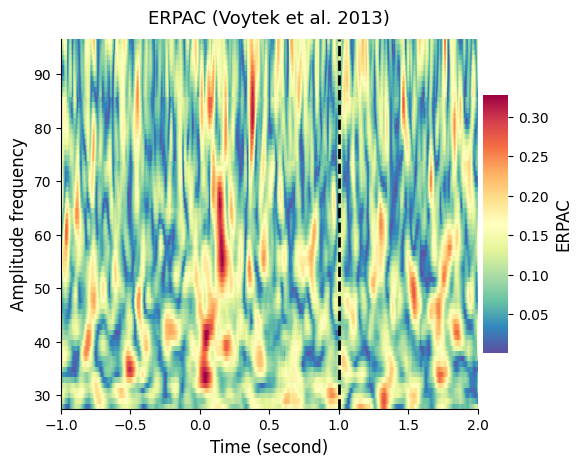

In [13]:
# define an ERPAC object
p = EventRelatedPac(f_pha=[2, 5], f_amp=(25, 100, 5, 1))
time = epochs.times
# method for correcting p-values for multiple comparisons
mcp = 'bonferroni'
# extract phases and amplitudes
erpac = p.filterfit(sf, data, method='circular', mcp=mcp).squeeze()
# get the p-values and squeeze unused dimensions
pvalues = p.pvalues.squeeze()
# set to nan everywhere it's not significant
erpac[pvalues > 1] = np.nan

vmin, vmax = np.nanmin(erpac), np.nanmax(erpac)

p.pacplot(erpac, time, p.yvec, xlabel='Time (second)',
          cmap='Spectral_r', ylabel='Amplitude frequency', title=p.method,
          cblabel='ERPAC', rmaxis=True, vmin=vmin, vmax=vmax)
plt.axvline(1., linestyle='--', color='k', linewidth=2)

p.show()

Event Related PAC object defined
    Compute Gaussian-Copula ERPAC


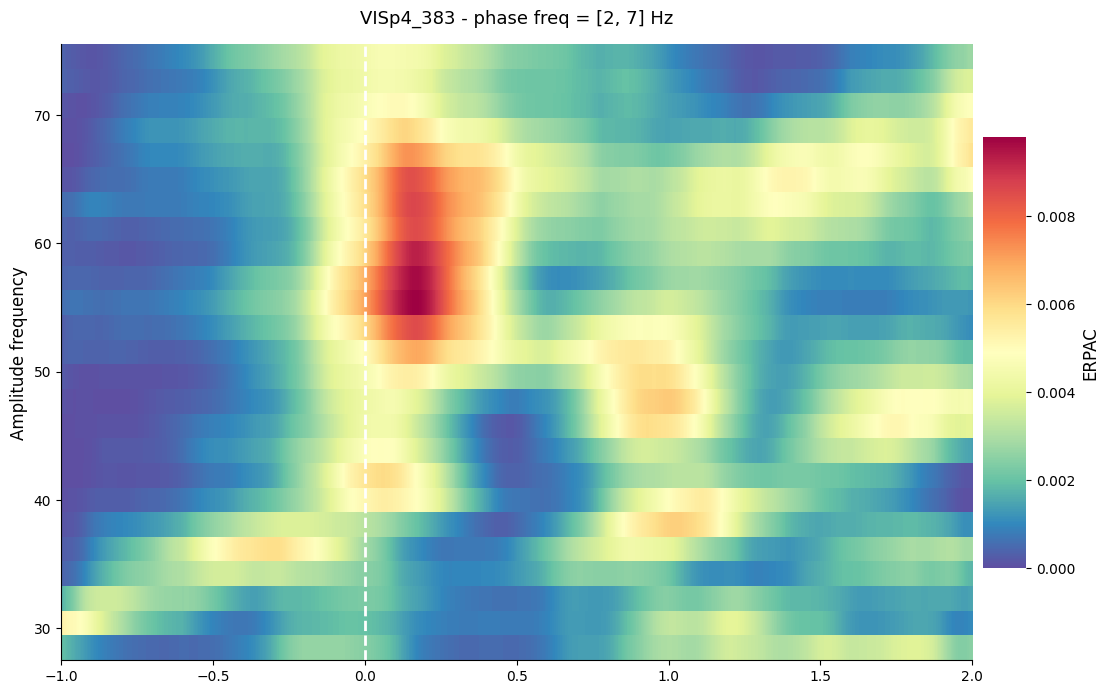

In [14]:
p = EventRelatedPac(f_pha=[2, 7], f_amp=(25, 80, 5, 2))

# extract phases and amplitudes
pha = p.filter(sf, data, ftype='phase', n_jobs=3)
amp = p.filter(sf, data, ftype='amplitude', n_jobs=3)


# implemented ERPAC methods
methods = [ 'gc']

plt.figure(figsize=(14, 8))
for n_m, m in enumerate(methods):
    # compute the erpac
    erpac = p.fit(pha, amp, method=m, smooth=100, n_jobs=3).squeeze()

    # plot
    plt.subplot(len(methods), 1, n_m + 1)
    p.pacplot(erpac, time, p.yvec, xlabel='Time (second)' * n_m,
            cmap='Spectral_r', ylabel='Amplitude frequency', title=f'{ch} - phase freq = [2, 7] Hz',
            cblabel='ERPAC', vmin=0., rmaxis=True)
    plt.axvline(0, linestyle='--', color='w', linewidth=2)

In [ ]:
p = EventRelatedPac(f_pha=[8, 20], f_amp=(30, 80, 5, 2))

# extract phases and amplitudes
pha = p.filter(sf, data, ftype='phase', n_jobs=3)
amp = p.filter(sf, data, ftype='amplitude', n_jobs=3)


# implemented ERPAC methods
methods = [ 'gc']

plt.figure(figsize=(14, 8))
for n_m, m in enumerate(methods):
    # compute the erpac
    erpac = p.fit(pha, amp, method=m,  n_jobs=3).squeeze()

    # plot
    plt.subplot(len(methods), 1, n_m + 1)
    p.pacplot(erpac, time, p.yvec, xlabel='Time (second)' * n_m,
            cmap='Spectral_r', ylabel='Amplitude frequency', title=f'{ch} - phase freq = [2, 7] Hz',
            cblabel='ERPAC', vmin=0., rmaxis=True)
    plt.axvline(0, linestyle='--', color='w', linewidth=2)

In [41]:

def compare_ERPAC(pid, n_jobs=5):
    epoch_path = f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/lfp_{pid}_epoched.fif'

    epochs = mne.read_epochs(epoch_path, preload=True)
    sf = epochs.info['sfreq']
    meta = epochs.metadata.reset_index()

    stim_indices = np.where(((meta['contrastLeft'] > 0.5) | (meta['contrastRight'] > 0.5)))[0]
    no_stim_indices = np.where(((meta['contrastLeft'] == 0) & (meta['contrastRight'] == 0)))[0]
    contrast_25_indices = np.where(((meta['contrastLeft'] == 0.25) | (meta['contrastRight'] == 0.25)))[0]
    contrast_12_indices = np.where(((meta['contrastLeft'] == 0.125) | (meta['contrastRight'] == 0.125)))[0]
    contrast_6_indices = np.where(((meta['contrastLeft'] == 0.0625) | (meta['contrastRight'] == 0.0625)))[0]

    afterstim_all_channel = []
    beforestim_all_channel = []
    afterstim_contrast100_list = []
    afterstim_contrast0_list = []
    afterstim_contrast25_list = []
    afterstim_contrast12_list = []
    afterstim_contrast6_list = []
    channel_names = []

    for ch in epochs.ch_names:
        epoch = epochs.copy().pick_channels([ch])

        # Extract data from epochs
        data = epoch.get_data().squeeze()  # Shape: (n_epochs, n_channels, n_times)
        data = data[:, 250:1000]
        p = EventRelatedPac(f_pha=[2, 7], f_amp=(25, 80, 5, 2))

        # extract phases and amplitudes
        pha = p.filter(sf, data, ftype='phase', n_jobs=n_jobs)
        amp = p.filter(sf, data, ftype='amplitude', n_jobs=n_jobs)
        erpac = p.fit(pha, amp, method='gc', n_jobs=n_jobs).squeeze()

        std = erpac.std(axis=(0, 1))
        mean = erpac.mean(axis=(0, 1))
        normalized_erpac = (erpac - mean) / std

        beforestim = normalized_erpac[:, 0:250].mean(axis=(0, 1))
        afterstim = normalized_erpac[:, 250:750].mean(axis=(0, 1))
        


        afterstim_all_channel.append(afterstim)
        beforestim_all_channel.append(beforestim)


        channel_names.append(ch)

    df = pd.DataFrame({
        'Channel': channel_names,
        'BeforeStim': beforestim_all_channel,
        'AfterStim': afterstim_all_channel,
    })

    # Save DataFrame to a CSV file
    save_path = f'/mnt/data/AdaptiveControl/IBLrawdata/TF_data/{pid}/PAC_stime_effect.csv'
    df.to_csv(save_path, index=False)
    
path = '/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/preprocessing/clean_data.csv'
df = pd.read_csv(path)

pids = df['pid'].values
for i, pid in enumerate (pids):
    
    executor = submitit.AutoExecutor(folder="logs")
    executor.update_parameters(mem_gb=20, timeout_min=600, slurm_partition="CPU", cpus_per_task=5)
    jobs = executor.submit(compare_ERPAC, pid)   




/tmp/ipykernel_204066/2694161690.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([afterstim_all_channel, beforestim_all_channel], labels=['After Stim', 'Before Stim'])


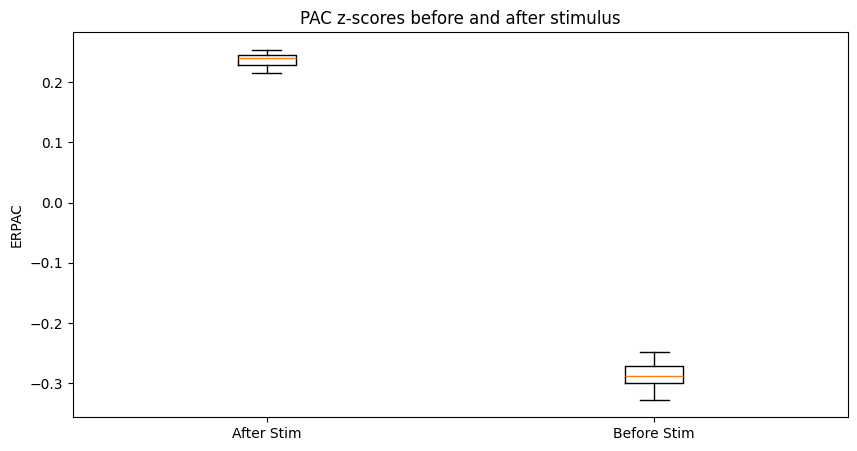

In [38]:
# Convert lists to numpy arrays for easier manipulation
afterstim_all_channel = np.array(afterstim_all_channel)
beforestim_all_channel = np.array(beforestim_all_channel)


# box plot of the ERPAC values
plt.figure(figsize=(10, 5))
plt.boxplot([afterstim_all_channel, beforestim_all_channel], labels=['After Stim', 'Before Stim'])
plt.ylabel('ERPAC')
plt.title('PAC z-scores before and after stimulus')
plt.show()

In [1]:
import pandas as pd
import glob
import os
import pickle

def aggregate_ERPAC_results(pid_list):
    all_results = []

    for pid in pid_list:
       
        file_path = f'/mnt/data/AdaptiveControl/IBLrawdata/TF_data/{pid}/PAC_stime_effect.csv'
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df['PID'] = pid
            all_results.append(df)


    # Combine all the results into a single DataFrame
    aggregated_df = pd.concat(all_results, ignore_index=True)
    
    
    return aggregated_df

path = '/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/preprocessing/clean_data.csv'
df = pd.read_csv(path)

pids = df['pid'].values

aggregated_results = aggregate_ERPAC_results(pids)


In [45]:
aggregated_results.to_csv('pac_stim_aggregated', index=False)

In [ ]:
import pandas as pd
from scipy.stats import ttest_rel, f_oneway
import matplotlib.pyplot as plt
import seaborn as sns
import os
data = aggregated_results
data['Layer'] = data['Channel'].str.extract(r'VISp(\d)[ab]?')

# Perform paired t-tests for each subject (PID)
subject_ttests = data.groupby('PID').apply(lambda x: ttest_rel(x['BeforeStim'], x['AfterStim']))

# Convert the results to a more readable format
subject_ttests_df = subject_ttests.apply(lambda x: pd.Series({'t-statistic': x.statistic, 'p-value': x.pvalue}))

# Calculate the difference (After - Before) for ANOVA analysis
data['StimulusEffect'] = data['AfterStim'] - data['BeforeStim']

# Perform ANOVA to examine if the stimulus effect varies across different layers
anova_results = f_oneway(*[data[data['Layer'] == str(layer)]['StimulusEffect'] for layer in range(1, 7)])

# Directory to save plots
output_dir = 'subject_plots'
os.makedirs(output_dir, exist_ok=True)

# Plotting each subject separately with layers
for pid in data['PID'].unique():
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Layer', y='value', hue='variable', 
                data=pd.melt(data[data['PID'] == pid], id_vars=['PID', 'Layer'], value_vars=['BeforeStim', 'AfterStim']))
    plt.title(f'Subject {pid} - Comparison of Before and After Stimulus Across Layers')
    plt.ylabel('Response')
    plt.xlabel('VISp Layer')
    plt.legend(title='Condition')
    plt.show()

In [ ]:
data = epoch.get_data().squeeze()  # Shape: (n_epochs, n_channels, n_times)
data = data[0:250, 500:1000]
# First, let's use the MVL, without any further correction by surrogates :
p = Pac(idpac=(6, 1, 4), f_pha=(2, 7, 2, .3), f_amp=(25, 70, 5, 2),
        verbose=False)

plt.figure(figsize=(18, 9))
# Define several cycle options for the fir1 (eegfilt like) filter :
print('Filtering with fir1 filter')
for i, k in enumerate([(1, 3), (2, 4), (3, 6)]):
    p.cycle = k
    xpac = p.filterfit(1024, data, n_jobs=1)
    plt.subplot(2, 3, i + 1)
    p.comodulogram(xpac.mean(-1), title='Fir1 - cycle ' + str(k))

# Define several wavelet width :
p.dcomplex = 'wavelet'
print('Filtering with wavelets')
for i, k in enumerate([7, 9, 12]):
    p.width = k
    xpac = p.filterfit(1024, data)
    plt.subplot(2, 3, i + 4)
    p.comodulogram(xpac.mean(-1), title='Wavelet - width ' + str(k))

plt.show()